In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from data_utils import *
from other_models import *

Using TensorFlow backend.


In [4]:
time_series_dir = '/Users/linggeli/cnn_graph/data/time_series/cup/'
behavioral_dir = '/Users/linggeli/cnn_graph/data/fMRIbehav/cup/'

In [5]:
subject_id_list = get_subject_id(time_series_dir)

In [6]:
print(subject_id_list)

[3748, 2330, 2132, 2085, 2091, 3416, 2046, 2250, 2292, 3198, 2286, 2047, 2090, 2084, 2127, 2133, 3777, 2119, 2131, 2086, 2079, 2290, 2253, 2247, 2050, 2078, 3399, 2124, 2118, 2336, 2120, 2134, 2108, 2295, 3821, 2256, 2243, 2294, 3411, 3377, 2096, 2109, 2121, 3029, 2323, 2309, 3003, 2137, 2123, 2080, 3822, 2296, 2241, 2255, 3638, 3360, 2081, 2122, 2136, 2334, 2192, 2025, 2185, 2191, 2152, 3476, 2032, 2026, 3648, 2231, 3107, 2027, 2033, 2153, 2190, 3932, 2180, 2194, 2143, 2157, 2023, 2235, 2221, 2209, 3103, 3102, 3116, 2234, 2022, 2036, 2156, 2142, 3062, 3060, 2197, 2154, 2140, 2020, 2237, 2223, 2021, 2169, 2141, 2196, 3075, 3087, 2170, 2164, 2038, 2004, 3130, 2206, 2212, 2213, 3643, 2005, 2165, 2171, 3051, 2173, 2239, 2210, 2006, 3481, 2166, 3720, 3283, 2189, 2162, 2176, 2016, 2002, 3137, 2003, 2017, 2177, 2188, 3043, 3096, 2149, 2001, 2203, 2216, 2028, 2148, 2160, 3040, 2113, 2098, 2067, 3190, 2259, 3191, 3344, 2106, 3218, 2304, 2310, 2338, 2104, 2110, 2058, 2070, 2064, 2299, 3811, 227

In [7]:
N_COEF = 5

In [12]:
X = get_all_features(time_series_dir, behavioral_dir, subject_id_list, 
                        n_time=64, coef_idx=range(N_COEF))
y = get_all_labels(behavioral_dir, subject_id_list) - 1

100%|██████████| 209/209 [00:32<00:00,  6.45it/s]


In [13]:
#X = X[:, :100, :]
print(X.shape)
print(y.shape)

(836, 375, 5)
(836,)


In [14]:
n_train = 600
n_val = 200

np.random.seed(0)
indices = np.random.permutation(X.shape[0])

In [15]:
X_train = X[indices[:n_train]]
X_val   = X[indices[n_train:n_train+n_val]]
X_test  = X[indices[n_train+n_val:]]

y_train = y[indices[:n_train]]
y_val   = y[indices[n_train:n_train+n_val]]
y_test  = y[indices[n_train+n_val:]]

In [16]:
from sklearn import preprocessing

In [17]:
X_vec = X.reshape((X.shape[0], X.shape[1] * N_COEF))
X_vec = preprocessing.scale(X_vec)
X_train_vec = X_vec[indices[:n_train]]
X_val_vec   = X_vec[indices[n_train:n_train+n_val]]
X_test_vec  = X_vec[indices[n_train+n_val:]]

In [18]:
print(X_vec.shape)

(836, 1875)


In [35]:
model = LogisticRegressionCV(cv=10, penalty='l1', solver='liblinear')

In [36]:
model.fit(X_train_vec, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [37]:
print(model.C_[0])

1291.5496650148827


In [38]:
y_hat = model.predict(X_val_vec)
print(np.mean(y_hat == y_val))

0.65


In [58]:
y_prob = model.predict_proba(X_val_vec)[:, 1]

In [59]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [60]:
print(X_vec.shape)

(836, 500)


In [64]:
model = Sequential()
model.add(Dense(100, input_shape=(X.shape[1] * N_COEF,), activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_6 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_7 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 54,981
Trainable params: 54,981
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [66]:
hist = model.fit(X_train_vec, y_train, batch_size=100, epochs=10, validation_data=(X_val_vec, y_val))

Train on 600 samples, validate on 200 samples
Epoch 1/10
600/600 [==============================] - 1s 993us/step - loss: 0.7346 - acc: 0.5433 - val_loss: 0.6997 - val_acc: 0.5200
Epoch 2/10
600/600 [==============================] - 0s 59us/step - loss: 0.5944 - acc: 0.6550 - val_loss: 0.6747 - val_acc: 0.5500
Epoch 3/10
600/600 [==============================] - 0s 57us/step - loss: 0.4947 - acc: 0.7783 - val_loss: 0.6681 - val_acc: 0.6200
Epoch 4/10
600/600 [==============================] - 0s 58us/step - loss: 0.4551 - acc: 0.8083 - val_loss: 0.6694 - val_acc: 0.6350
Epoch 5/10
600/600 [==============================] - 0s 58us/step - loss: 0.3912 - acc: 0.8500 - val_loss: 0.6788 - val_acc: 0.6350
Epoch 6/10
600/600 [==============================] - 0s 54us/step - loss: 0.3442 - acc: 0.8817 - val_loss: 0.6813 - val_acc: 0.6500
Epoch 7/10
600/600 [==============================] - 0s 57us/step - loss: 0.3006 - acc: 0.9033 - val_loss: 0.6961 - val_acc: 0.6550
Epoch 8/10
600/600 [==

In [88]:
y_hat = model.predict(X_val_vec)
print(y_hat.shape)

(200, 1)


In [89]:
print(X_train.shape)

(600, 100, 5)


In [90]:
from keras import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, AveragePooling2D

In [91]:
input_image = Input(shape=(100, 5, 1))
x = Conv2D(20, (5, 5), padding='same', activation='relu')(input_image)
x = AveragePooling2D((5, 5))(x)
#x = Conv2D(20, (3, 3), padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
y = Dense(1, activation='sigmoid')(x)
conv_model = Model(input_image, y)
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 5, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 5, 20)        520       
_________________________________________________________________
average_pooling2d_4 (Average (None, 20, 1, 20)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                8020      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 21        
Total para

In [92]:
conv_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [93]:
X_train = (X_train - np.mean(X)) / np.std(X)
X_val = (X_val - np.mean(X)) / np.std(X)
X_train_image = np.expand_dims(X_train, axis=-1)
X_val_image = np.expand_dims(X_val, axis=-1)

In [100]:
conv_model.fit(X_train_image, y_train, batch_size=100, epochs=10, verbose=1, validation_data=(X_val_image, y_val))

Train on 600 samples, validate on 200 samples
Epoch 1/10
600/600 [==============================] - 0s 368us/step - loss: 0.5292 - acc: 0.7433 - val_loss: 0.6318 - val_acc: 0.6750
Epoch 2/10
600/600 [==============================] - 0s 345us/step - loss: 0.5352 - acc: 0.7200 - val_loss: 0.6328 - val_acc: 0.7000
Epoch 3/10
600/600 [==============================] - 0s 343us/step - loss: 0.5282 - acc: 0.7333 - val_loss: 0.6246 - val_acc: 0.7000
Epoch 4/10
600/600 [==============================] - 0s 342us/step - loss: 0.5350 - acc: 0.7433 - val_loss: 0.6281 - val_acc: 0.6900
Epoch 5/10
600/600 [==============================] - 0s 338us/step - loss: 0.5189 - acc: 0.7600 - val_loss: 0.6199 - val_acc: 0.7050
Epoch 6/10
600/600 [==============================] - 0s 340us/step - loss: 0.5271 - acc: 0.7383 - val_loss: 0.6420 - val_acc: 0.6850
Epoch 7/10
600/600 [==============================] - 0s 354us/step - loss: 0.5205 - acc: 0.7500 - val_loss: 0.6262 - val_acc: 0.7100
Epoch 8/10
600/6

In [81]:
y_true = y_val
y_hat = conv_model.predict(X_val_image)[:, 0]

In [82]:
from sklearn.metrics import roc_curve, auc

In [83]:
fpr, tpr, _ = roc_curve(y_true, y_hat)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.5906315684115704


Text(0,0.5,'True Positive Rate')

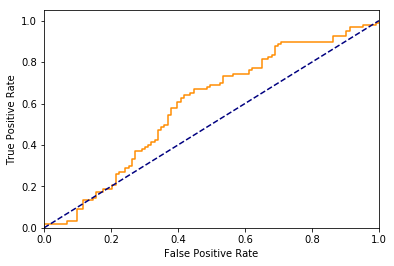

In [87]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [96]:
'Model architecture: {arch}; Dropout probability: {p}'.format(arch=[40, 20], p=0.1)

'Model architecture: [40, 20]; Dropout probability: 0.1'

In [97]:
print('Number of filters: {c}; Dense layer size: {d}; '
      'Dropout probability: {p}'.format(c=10, d=20, p=0.1))

Number of filters: 10; Dense layer size: 20; Dropout probability: 0.1
